In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# load dataset
df = pd.read_csv('fraud.csv')
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# count of fraud and non-fraud cases
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  6354407


In [4]:
# correct for oversampling of non-fraud cases
non_fraud_df = non_fraud_df.sample(n=len(fraud_df)*4)   # 4 times the number of fraud cases
df = pd.concat([fraud_df, non_fraud_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)   # shuffle
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,184,TRANSFER,73486.80,C1621868910,73486.80,0.00,C80114105,0.00,0.00,1,0
1,18,CASH_IN,19898.34,C167075635,5525511.55,5545409.89,C640751715,775145.10,755246.76,0,0
2,162,CASH_OUT,162824.91,C99508900,0.00,0.00,C390930468,6908173.73,7070998.64,0,0
3,34,CASH_OUT,143178.07,C1299272272,0.00,0.00,C303130996,977387.23,1120565.30,0,0
4,379,PAYMENT,15230.09,C1853702825,0.00,0.00,M1060924418,0.00,0.00,0,0


In [5]:
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  32852


In [6]:
# check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# use label encoding for type, nameOrig, nameDest
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,184,4,73486.80,13231,73486.80,0.00,26024,0.00,0.00,1,0
1,18,0,19898.34,14246,5525511.55,5545409.89,23545,775145.10,755246.76,0,0
2,162,1,162824.91,40965,0.00,0.00,19754,6908173.73,7070998.64,0,0
3,34,1,143178.07,6371,0.00,0.00,18442,977387.23,1120565.30,0,0
4,379,3,15230.09,18156,0.00,0.00,29264,0.00,0.00,0,0


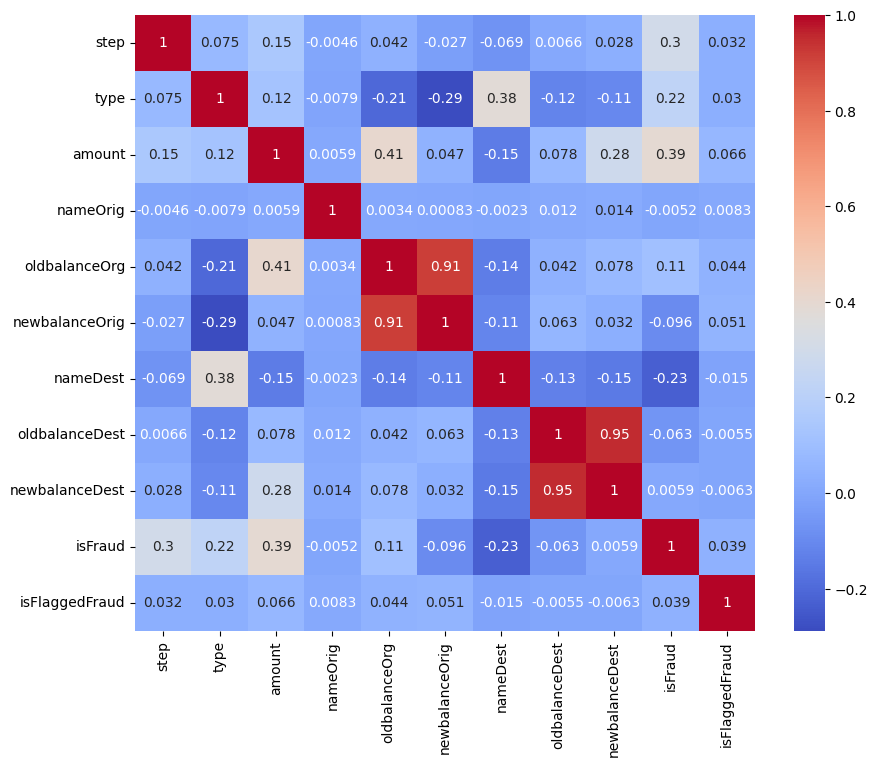

In [8]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
# split into train and test sets
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# scale the data for all but isFraud
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
# train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, lr_y_pred))

Accuracy score:  0.9398514550103495


In [12]:
# train random forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [13]:
# evaluate model
rf_y_pred = random_forest.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print('Accuracy: ', accuracy_score(y_test, rf_y_pred))

[[6555   26]
 [  28 1604]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6581
           1       0.98      0.98      0.98      1632

    accuracy                           0.99      8213
   macro avg       0.99      0.99      0.99      8213
weighted avg       0.99      0.99      0.99      8213

Accuracy:  0.9934250578351395


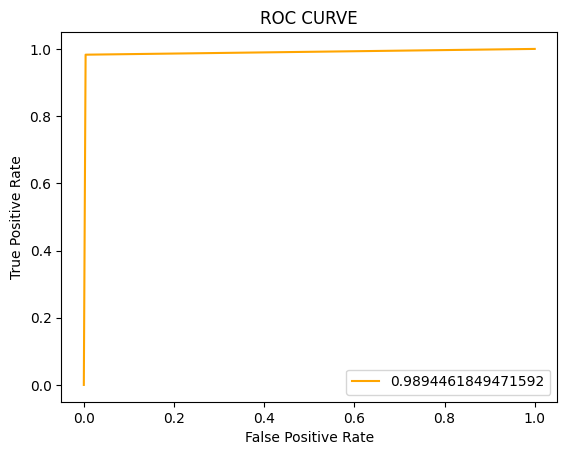

In [14]:
auc = roc_auc_score(y_test, rf_y_pred)
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()